In [1]:
import warnings
warnings.filterwarnings("ignore")

# Libraries ----
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import json
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
from collections import Counter

In [2]:
# ----  Load data ----
df=pd.read_csv(r"C:\Users\Swefi Store\Desktop\Medical files\HDHI Admission data.csv")

In [3]:
# Quick inspect
print("Initial shape:", df.shape)
print(df.columns.tolist()[:60])

Initial shape: (15757, 56)
['SNO', 'MRD No.', 'D.O.A', 'D.O.D', 'AGE', 'GENDER', 'RURAL', 'TYPE OF ADMISSION-EMERGENCY/OPD', 'month year', 'DURATION OF STAY', 'duration of intensive unit stay', 'OUTCOME', 'SMOKING ', 'ALCOHOL', 'DM', 'HTN', 'CAD', 'PRIOR CMP', 'CKD', 'HB', 'TLC', 'PLATELETS', 'GLUCOSE', 'UREA', 'CREATININE', 'BNP', 'RAISED CARDIAC ENZYMES', 'EF', 'SEVERE ANAEMIA', 'ANAEMIA', 'STABLE ANGINA', 'ACS', 'STEMI', 'ATYPICAL CHEST PAIN', 'HEART FAILURE', 'HFREF', 'HFNEF', 'VALVULAR', 'CHB', 'SSS', 'AKI', 'CVA INFRACT', 'CVA BLEED', 'AF', 'VT', 'PSVT', 'CONGENITAL', 'UTI', 'NEURO CARDIOGENIC SYNCOPE', 'ORTHOSTATIC', 'INFECTIVE ENDOCARDITIS', 'DVT', 'CARDIOGENIC SHOCK', 'SHOCK', 'PULMONARY EMBOLISM', 'CHEST INFECTION']


In [4]:
# ----  Clean column names ----
# strip whitespace and replace spaces with underscores for convenience
df.columns = [col.strip().replace(' ', '_').replace('-', '_').replace('/', '_') for col in df.columns]
print("Columns after clean:", df.columns.tolist())

Columns after clean: ['SNO', 'MRD_No.', 'D.O.A', 'D.O.D', 'AGE', 'GENDER', 'RURAL', 'TYPE_OF_ADMISSION_EMERGENCY_OPD', 'month_year', 'DURATION_OF_STAY', 'duration_of_intensive_unit_stay', 'OUTCOME', 'SMOKING', 'ALCOHOL', 'DM', 'HTN', 'CAD', 'PRIOR_CMP', 'CKD', 'HB', 'TLC', 'PLATELETS', 'GLUCOSE', 'UREA', 'CREATININE', 'BNP', 'RAISED_CARDIAC_ENZYMES', 'EF', 'SEVERE_ANAEMIA', 'ANAEMIA', 'STABLE_ANGINA', 'ACS', 'STEMI', 'ATYPICAL_CHEST_PAIN', 'HEART_FAILURE', 'HFREF', 'HFNEF', 'VALVULAR', 'CHB', 'SSS', 'AKI', 'CVA_INFRACT', 'CVA_BLEED', 'AF', 'VT', 'PSVT', 'CONGENITAL', 'UTI', 'NEURO_CARDIOGENIC_SYNCOPE', 'ORTHOSTATIC', 'INFECTIVE_ENDOCARDITIS', 'DVT', 'CARDIOGENIC_SHOCK', 'SHOCK', 'PULMONARY_EMBOLISM', 'CHEST_INFECTION']


In [5]:
# ----  Convert obvious numeric columns ----
# replace 'NaN' string if present, and coerce numeric columns
df = df.replace('NaN', np.nan)

In [6]:
# example numeric columns list (auto-detect candidates)
numeric_cols_candidates = ['AGE','HB','TLC','PLATELETS','GLUCOSE','UREA','CREATININE','BNP','EF',
                           'DURATION_OF_STAY','duration_of_intensive_unit_stay']

In [7]:
# keep only those that exist
numeric_cols = [c for c in numeric_cols_candidates if c in df.columns]
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

In [8]:
# ----  Dates: parse DOA and DOD, compute stay if missing ----
for c in ['D.O.A','D.O.D','DOA','DOD']:
    if c in df.columns:
        # ensure consistent name
        df = df.rename(columns={c: c.replace('.', '_')})

In [9]:
# now check
if 'D_O_A' in df.columns and 'D_O_D' in df.columns:
    df['D_O_A'] = pd.to_datetime(df['D_O_A'], errors='coerce', dayfirst=False)
    df['D_O_D'] = pd.to_datetime(df['D_O_D'], errors='coerce', dayfirst=False)
    # compute length of stay in days
    df['LOS_days'] = (df['D_O_D'] - df['D_O_A']).dt.days
    # if LOS missing use given DURATION_OF_STAY
    if 'DURATION_OF_STAY' in df.columns:
        df['LOS_days'] = df['LOS_days'].fillna(df['DURATION_OF_STAY'])
    df['LOS_days'] = pd.to_numeric(df['LOS_days'], errors='coerce')
    if 'LOS_days' not in numeric_cols:
        numeric_cols.append('LOS_days')

In [10]:
# ----  Target: map OUTCOME to binary ----
# view counts
print("Outcome value counts:\n", df['OUTCOME'].value_counts(dropna=False))

Outcome value counts:
 OUTCOME
DISCHARGE    13756
EXPIRY        1105
DAMA           896
Name: count, dtype: int64


In [11]:
# Keep DISCHARGE vs EXPIRY
df = df[df['OUTCOME'].isin(['DISCHARGE', 'EXPIRY'])]
df['TARGET'] = df['OUTCOME'].map({'DISCHARGE':0, 'EXPIRY':1})
print("After filtering shape:", df.shape)
print("TARGET distribution:", Counter(df['TARGET']))

After filtering shape: (14861, 58)
TARGET distribution: Counter({0: 13756, 1: 1105})


In [12]:
# ----  Drop unneeded identifiers ----
drop_cols = []
for id_cand in ['SNO','MRD_No.','MRD_No','MRD','MRD_No_']:
    if id_cand in df.columns:
        drop_cols.append(id_cand)
# Also drop original OUTCOME text column (keep TARGET)
drop_cols += ['OUTCOME'] if 'OUTCOME' in df.columns else []
# drop month_year if not useful
if 'month_year' in df.columns:
    # keep if wanted; for now drop to avoid leakage
    drop_cols.append('month_year')

df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')
print("Dropped cols:", drop_cols)

Dropped cols: ['SNO', 'MRD_No.', 'OUTCOME', 'month_year']


In [13]:
# ----  Candidate features: categorize columns ----
# categorical binary columns (0/1) - auto detect many columns that look binary
cat_cols = []
for c in df.columns:
    if c in ['TARGET'] + numeric_cols:
        continue
    if df[c].dropna().isin([0,1]).all() and df[c].nunique() <= 3:
        cat_cols.append(c)

In [14]:
# manually include known categoricals
for manual in ['GENDER','RURAL','TYPE_OF_ADMISSION_EMERGENCY_OPD']:
    if manual in df.columns and manual not in cat_cols:
        cat_cols.append(manual)

In [15]:
# final numeric cols list (remove any bad ones)
numeric_cols = [c for c in numeric_cols if c in df.columns]
print("Numeric cols:", numeric_cols)
print("Categorical cols:", cat_cols)


Numeric cols: ['AGE', 'HB', 'TLC', 'PLATELETS', 'GLUCOSE', 'UREA', 'CREATININE', 'BNP', 'EF', 'DURATION_OF_STAY', 'duration_of_intensive_unit_stay', 'LOS_days']
Categorical cols: ['SMOKING', 'ALCOHOL', 'DM', 'HTN', 'CAD', 'PRIOR_CMP', 'CKD', 'RAISED_CARDIAC_ENZYMES', 'SEVERE_ANAEMIA', 'ANAEMIA', 'STABLE_ANGINA', 'ACS', 'STEMI', 'ATYPICAL_CHEST_PAIN', 'HEART_FAILURE', 'HFREF', 'HFNEF', 'VALVULAR', 'CHB', 'SSS', 'AKI', 'CVA_INFRACT', 'CVA_BLEED', 'AF', 'VT', 'PSVT', 'CONGENITAL', 'UTI', 'NEURO_CARDIOGENIC_SYNCOPE', 'ORTHOSTATIC', 'INFECTIVE_ENDOCARDITIS', 'DVT', 'CARDIOGENIC_SHOCK', 'SHOCK', 'PULMONARY_EMBOLISM', 'GENDER', 'RURAL', 'TYPE_OF_ADMISSION_EMERGENCY_OPD']


In [16]:
# ---- Missing value handling strategy (summary) ----
missing_summary = df[numeric_cols + cat_cols].isnull().mean().sort_values(ascending=False)
print("Missing rates (top):\n", missing_summary.head(20))

Missing rates (top):
 BNP                          0.581926
EF                           0.102416
GLUCOSE                      0.047507
PLATELETS                    0.016957
TLC                          0.016284
HB                           0.014938
CREATININE                   0.014467
UREA                         0.013929
AGE                          0.000000
CVA_BLEED                    0.000000
PSVT                         0.000000
VT                           0.000000
AF                           0.000000
SSS                          0.000000
CVA_INFRACT                  0.000000
AKI                          0.000000
UTI                          0.000000
CONGENITAL                   0.000000
DVT                          0.000000
NEURO_CARDIOGENIC_SYNCOPE    0.000000
dtype: float64


In [17]:
# Simple imputation plan:
# - numeric: median
# - categorical: mode (most frequent)
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')


In [18]:
# ----  Build preprocessing pipelines ----
# Numeric transformer: impute -> scale
num_transformer = Pipeline(steps=[
    ('imputer', num_imputer),
    ('scaler', StandardScaler())
])

In [19]:
# Categorical transformer
# For binary categorical coded as 0/1 we don't one-hot; for others we do
binary_cat_cols = [c for c in cat_cols if set(df[c].dropna().unique()).issubset({0,1})]
ohe_cat_cols = [c for c in cat_cols if c not in binary_cat_cols]

cat_transformers = []
if binary_cat_cols:
    # keep as-is but impute
    cat_transformers.append(('binary', Pipeline([('imputer', cat_imputer)]), binary_cat_cols))
if ohe_cat_cols:
    cat_transformers.append(('ohe', Pipeline([('imputer', cat_imputer), ('ohe', OneHotEncoder(handle_unknown='ignore'))]), ohe_cat_cols))

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numeric_cols),
] + cat_transformers, remainder='drop', sparse_threshold=0)


In [20]:
# For debugging, see transformed feature names helper
def get_feature_names_from_column_transformer(column_transformer):
    """Returns feature names after ColumnTransformer (approximate)."""
    feature_names = []
    for name, trans, cols in column_transformer.transformers_:
        if name == 'remainder':
            continue
        if hasattr(trans, 'named_steps') and 'ohe' in trans.named_steps:
            ohe = trans.named_steps['ohe']
            names = ohe.get_feature_names_out(cols)
            feature_names.extend(list(names))
        else:
            feature_names.extend(list(cols))
    return feature_names

In [21]:
# ----  Train/test split ----
X = df[numeric_cols + cat_cols].copy()
y = df['TARGET'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Train/test shapes:", X_train.shape, X_test.shape, Counter(y_train), Counter(y_test))


Train/test shapes: (11888, 50) (2973, 50) Counter({0: 11004, 1: 884}) Counter({0: 2752, 1: 221})


In [22]:
# ----  Baseline model: Logistic Regression with class_weight ----
logpipe = Pipeline(steps=[('preproc', preprocessor),
                          ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear'))])

logpipe.fit(X_train, y_train)
y_pred = logpipe.predict(X_test)
y_proba = logpipe.predict_proba(X_test)[:,1]

print("--- Logistic Regression Report ---")
print(classification_report(y_test, y_pred, digits=4))
print("ROC AUC:", roc_auc_score(y_test, y_proba))



--- Logistic Regression Report ---
              precision    recall  f1-score   support

           0     0.9850    0.8848    0.9322      2752
           1     0.3673    0.8326    0.5097       221

    accuracy                         0.8809      2973
   macro avg     0.6761    0.8587    0.7210      2973
weighted avg     0.9391    0.8809    0.9008      2973

ROC AUC: 0.9446375486688414


In [23]:
# ----  Evaluate function ----
def evaluate_model(pipe, X_test, y_test, model_name="Model"):
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]
    print(f"=== {model_name} ===")
    print(classification_report(y_test, y_pred, digits=4))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.show()
    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC={roc_auc_score(y_test,y_proba):.3f})')
    plt.plot([0,1],[0,1],'--', color='grey')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title(f'{model_name} ROC curve'); plt.legend(); plt.show()
    # PR curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)
    plt.plot(recall, precision, label=f'AP={ap:.3f}')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title(f'{model_name} Precision-Recall'); plt.legend(); plt.show()


=== LogisticRegression (balanced) ===
              precision    recall  f1-score   support

           0     0.9850    0.8848    0.9322      2752
           1     0.3673    0.8326    0.5097       221

    accuracy                         0.8809      2973
   macro avg     0.6761    0.8587    0.7210      2973
weighted avg     0.9391    0.8809    0.9008      2973

ROC AUC: 0.9446375486688414


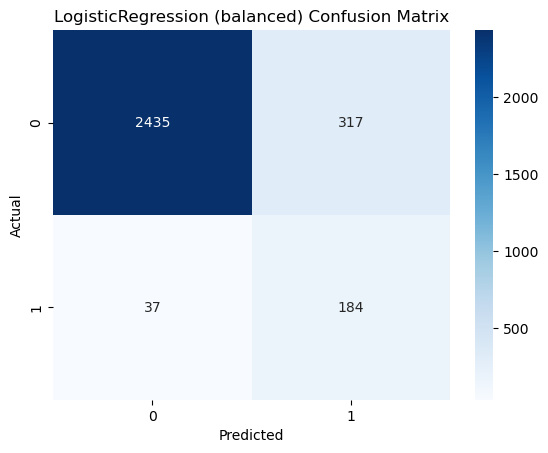

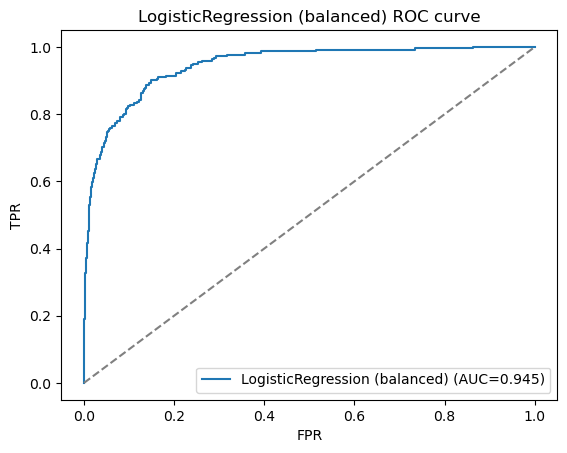

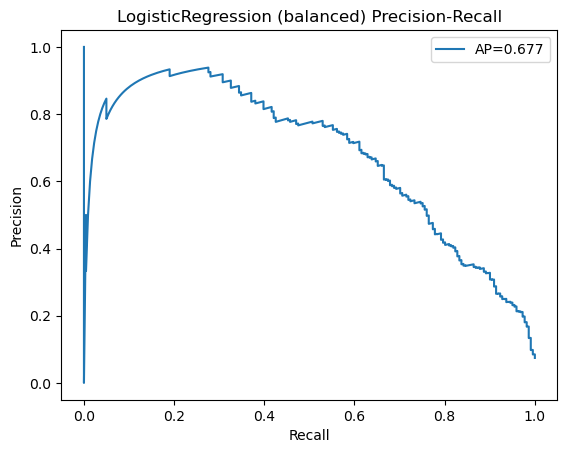

In [24]:
# Evaluate LR
evaluate_model(logpipe, X_test, y_test, "LogisticRegression (balanced)")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best RF params: {'clf__n_estimators': 400, 'clf__min_samples_split': 5, 'clf__max_depth': None, 'clf__class_weight': None}
=== RandomForest + SMOTE ===
              precision    recall  f1-score   support

           0     0.9817    0.9924    0.9870      2752
           1     0.8901    0.7692    0.8252       221

    accuracy                         0.9758      2973
   macro avg     0.9359    0.8808    0.9061      2973
weighted avg     0.9749    0.9758    0.9750      2973

ROC AUC: 0.981661218825634


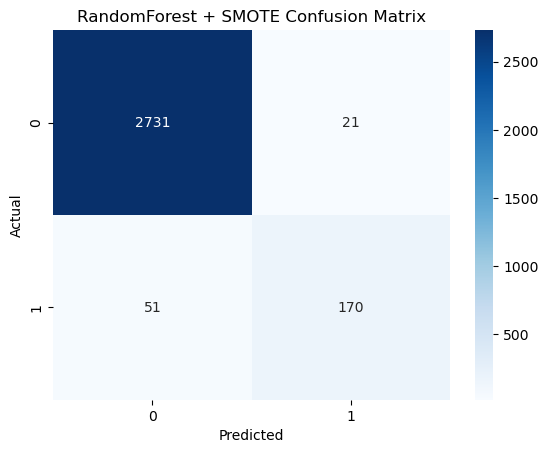

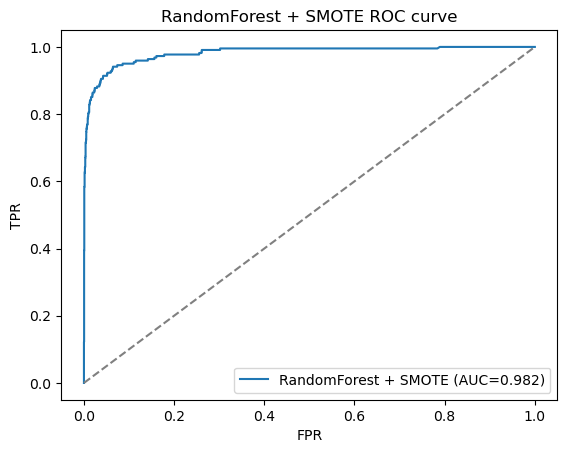

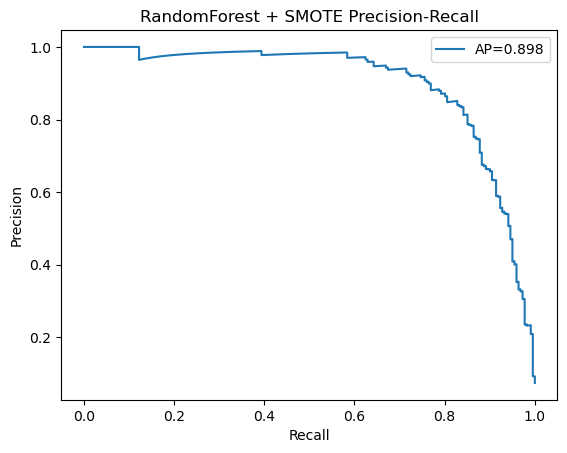

In [25]:
# ----  Random Forest with SMOTE in pipeline ----
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "1"  

rf = RandomForestClassifier(random_state=42, n_jobs=1)  

imb_pipe = ImbPipeline(steps=[
    ('preproc', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', rf)
])

# quick param search (use RandomizedSearch for speed)
param_dist = {
    'clf__n_estimators': [100, 200, 400],
    'clf__max_depth': [None, 6, 12],
    'clf__min_samples_split': [2, 5, 10],
    'clf__class_weight': [None, 'balanced']
}

rnd = RandomizedSearchCV(
    imb_pipe,
    param_distributions=param_dist,
    n_iter=12,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=1,                
    random_state=42
)

rnd.fit(X_train, y_train)
print("Best RF params:", rnd.best_params_)
best_rf_pipe = rnd.best_estimator_

evaluate_model(best_rf_pipe, X_test, y_test, "RandomForest + SMOTE")

Fitting 4 folds for each of 8 candidates, totalling 32 fits
Best XGB params: {'clf__scale_pos_weight': 12.447963800904978, 'clf__n_estimators': 200, 'clf__max_depth': 6, 'clf__learning_rate': 0.1}
=== XGBoost + SMOTE ===
              precision    recall  f1-score   support

           0     0.9912    0.9833    0.9872      2752
           1     0.8107    0.8914    0.8491       221

    accuracy                         0.9765      2973
   macro avg     0.9010    0.9373    0.9182      2973
weighted avg     0.9778    0.9765    0.9770      2973

ROC AUC: 0.9905556140166262


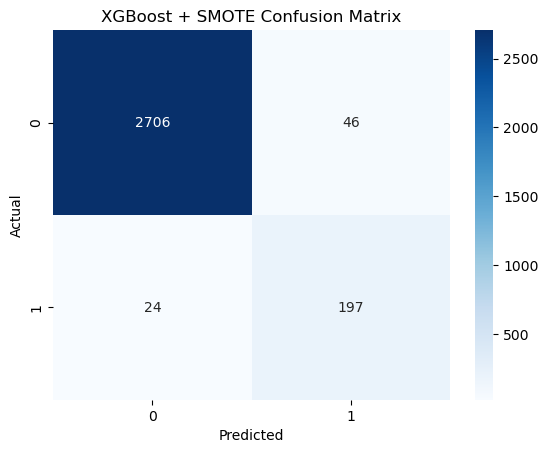

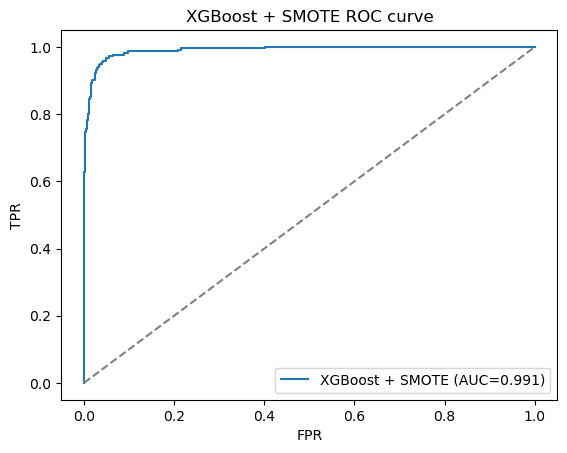

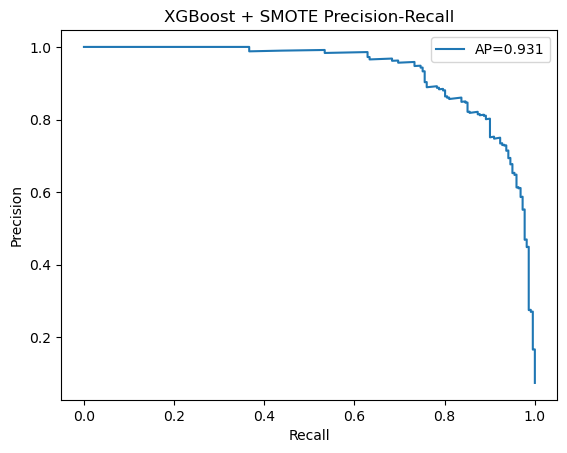

In [26]:
# ----  XGBoost (scale_pos_weight) ----
# compute scale_pos_weight = N_negative / N_positive
import xgboost as xgb
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
imb_xgb_pipe = ImbPipeline(steps=[('preproc', preprocessor),
                                  ('smote', SMOTE(random_state=42)),
                                  ('clf', xgb_clf)])
xgb_param = {
    'clf__n_estimators': [100,200],
    'clf__max_depth': [3,6],
    'clf__learning_rate': [0.01,0.1],
    'clf__scale_pos_weight': [scale_pos_weight, 1]
}
gscv_xgb = RandomizedSearchCV(imb_xgb_pipe, param_distributions=xgb_param, n_iter=8, scoring='roc_auc', cv=4, n_jobs=-1, random_state=42, verbose=1)
gscv_xgb.fit(X_train, y_train)
print("Best XGB params:", gscv_xgb.best_params_)
best_xgb_pipe = gscv_xgb.best_estimator_
evaluate_model(best_xgb_pipe, X_test, y_test, "XGBoost + SMOTE")

In [27]:
# ----  SHAP interpretation on best model (example using XGBoost) ----
# Get transformed training matrix and feature names
preprocessor.fit(X_train)
feature_names = get_feature_names_from_column_transformer(preprocessor)
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

                              Feature  Importance
51  TYPE_OF_ADMISSION_EMERGENCY_OPD_E    0.333878
45                              SHOCK    0.137279
27                              HFREF    0.106231
11                           LOS_days    0.060971
16                                CAD    0.030271
10    duration_of_intensive_unit_stay    0.026593
32                                AKI    0.025318
23                                ACS    0.021117
25                ATYPICAL_CHEST_PAIN    0.020263
34                          CVA_BLEED    0.019470
14                                 DM    0.017849
8                                  EF    0.015526
15                                HTN    0.014770
19             RAISED_CARDIAC_ENZYMES    0.010908
30                                CHB    0.010832
28                              HFNEF    0.009571
21                            ANAEMIA    0.009008
17                          PRIOR_CMP    0.008897
5                                UREA    0.008587


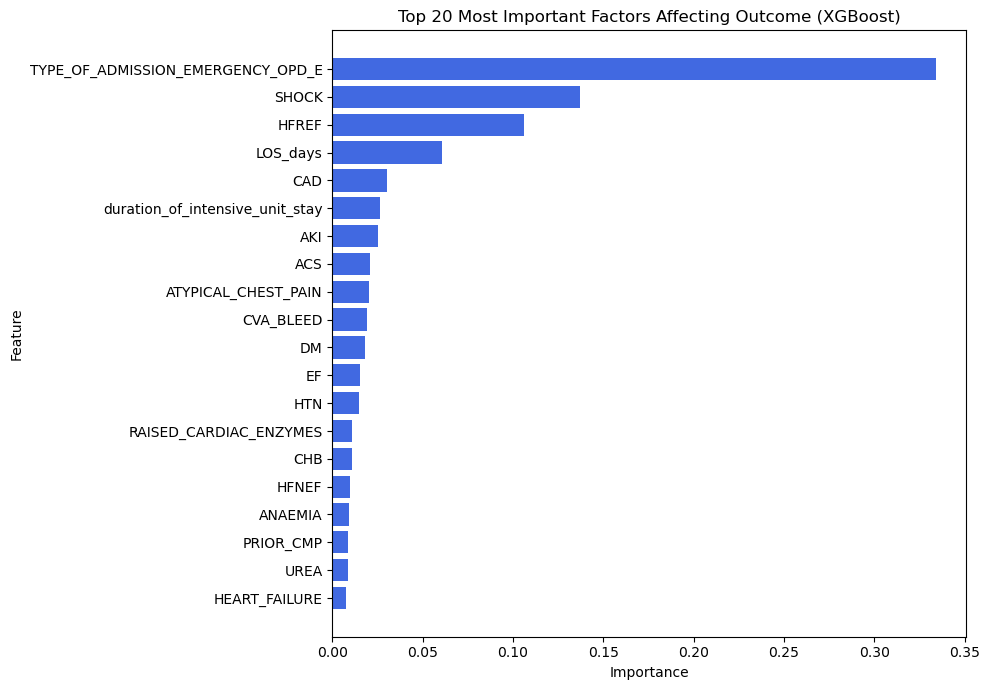

In [31]:
xgb_final = best_xgb_pipe.named_steps['clf']

feature_names = get_feature_names_from_column_transformer(best_xgb_pipe.named_steps['preproc'])

#  (feature importance)
importances = xgb_final.feature_importances_

feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


top_features = feat_imp.head(20)
print(top_features)

plt.figure(figsize=(10, 7))
plt.barh(top_features['Feature'][::-1], top_features['Importance'][::-1], color='royalblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 20 Most Important Factors Affecting Outcome (XGBoost)")
plt.tight_layout()
plt.show()


In [32]:
# ----  Save best model and artifacts ----
best_model = best_xgb_pipe  # or choose best among models by validation AUC
joblib.dump(best_model, 'best_outcome_model.pkl')
# Save features list
with open('feature_names.json','w') as f:
    json.dump(feature_names, f)
print("Saved model to best_outcome_model.pkl and features to feature_names.json")


Saved model to best_outcome_model.pkl and features to feature_names.json


In [33]:
# ----  Quick export of test predictions for analysis ----
test_preds = X_test.copy()
test_preds['true'] = y_test.values
test_preds['pred_proba'] = best_model.predict_proba(X_test)[:,1]
test_preds['pred_label'] = best_model.predict(X_test)
test_preds.to_csv('test_predictions_with_proba.csv', index=False)
print("Exported test predictions to test_predictions_with_proba.csv")



Exported test predictions to test_predictions_with_proba.csv
